In [56]:
# add parenthesis to help with visually disambiguating order of operations
def fmt_label(l: str):
    if l == '':
        return ''
    if len(l) > 1:
        return f"({l})"
    else:
        return l

# topo sort
def build_topo(node, _visited=set(), _topo=[]):
    if node not in _visited:
        _visited.add(node)
        for child in node._prev:
            build_topo(child)
        _topo.append(node)
    return _topo

class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self._backward = lambda: None
        self.grad = 0.0

    def __repr__(self):
        return f"Value(data={self.data}, grad={self.grad}, _op={'Scalar' if self._op == '' else self._op}, label={'N/A' if self.label == '' else self.label})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+', label='' if self.label == '' or other.label == '' else fmt_label('%s + %s' % (self.label, other.label)))

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out

    def __radd__(self, other):
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*', label=f"{fmt_label(self.label)}*{fmt_label(other.label)}")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other   

    def backward(self):
        topo = build_topo(self)
        self.grad = 1
        
        for v in reversed(topo):
            v._backward()

In [48]:
a = Value(5, label='a')
b = Value(3, label='b')
c = Value(7, label='c')
d = Value(2, label='d')

e = (a * b + c) * d

In [49]:
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [112]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ data %.4f | grad %.4f }" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [51]:
e.backward()

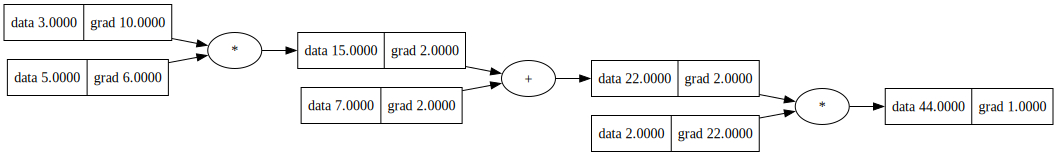

In [114]:
draw_dot(e)

In [106]:
import random
class Module:
    def zero_grad(self):
        for p in self.parameters():
            p.grad = 0

    def parameters(self):
        return []

class Neuron(Module):
    def __init__(self, num_inputs):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(num_inputs)]
        self.b = Value(0)
        
    def __call__(self, x):
        return sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer(Module):
    def __init__(self, num_inputs, num_outputs):
        self.neurons = [Neuron(num_inputs) for _ in range(num_outputs)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        params = []
        for n in self.neurons:
            params.extend(n.parameters())
        return params
    
class MLP(Module):
    def __init__(self, num_inputs, num_outputs):
        sz = [num_inputs] + num_outputs
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(num_outputs))]
    
    def __call__(self, x):
        for l in self.layers:
            x = l(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [110]:
l = MLP(3, [5, 1])

In [111]:
result = l([1, 2, 3])

In [109]:
l.parameters()

[Value(data=-0.15809816483683803, grad=0.0, _op=Scalar, label=N/A),
 Value(data=0.22290983005755427, grad=0.0, _op=Scalar, label=N/A),
 Value(data=0.37544294358063657, grad=0.0, _op=Scalar, label=N/A),
 Value(data=0, grad=0.0, _op=Scalar, label=N/A),
 Value(data=0.5022052272749209, grad=0.0, _op=Scalar, label=N/A),
 Value(data=0.33814319005648663, grad=0.0, _op=Scalar, label=N/A),
 Value(data=-0.4015670666617903, grad=0.0, _op=Scalar, label=N/A),
 Value(data=0, grad=0.0, _op=Scalar, label=N/A),
 Value(data=-0.03416562673857526, grad=0.0, _op=Scalar, label=N/A),
 Value(data=-0.861856582252257, grad=0.0, _op=Scalar, label=N/A),
 Value(data=-0.9141038006100266, grad=0.0, _op=Scalar, label=N/A),
 Value(data=0, grad=0.0, _op=Scalar, label=N/A),
 Value(data=0.44871999160051934, grad=0.0, _op=Scalar, label=N/A),
 Value(data=-0.40886691603595016, grad=0.0, _op=Scalar, label=N/A),
 Value(data=-0.9065940751025969, grad=0.0, _op=Scalar, label=N/A),
 Value(data=0, grad=0.0, _op=Scalar, label=N/A),

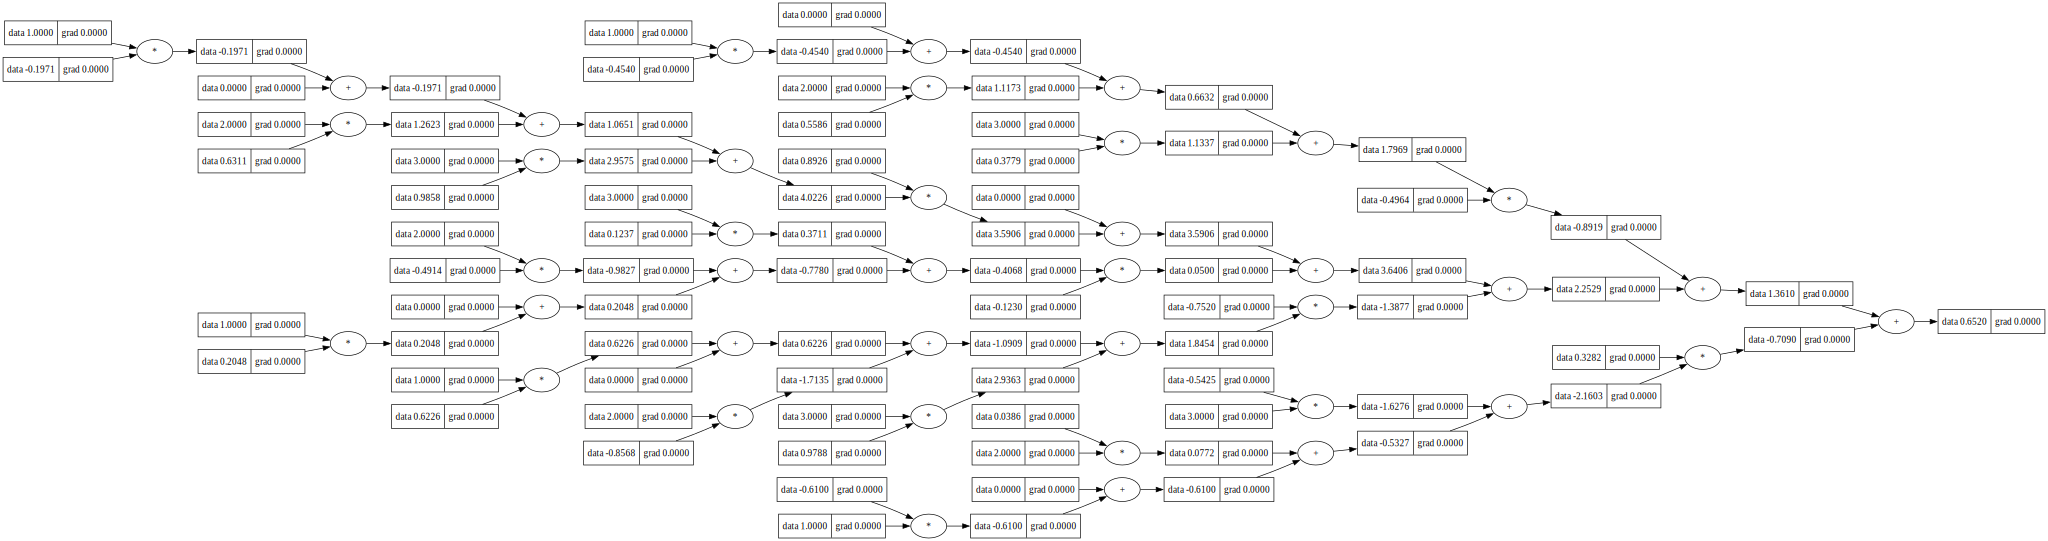

In [113]:
draw_dot(result)